# Predicting Student Success: Early Identification of Dropout Risks and Targeted Interventions

## Identify the Supervised Machine Learning Problem:
- Use machine learning to develop a model for predicting student dropouts, enabling targeted interventions to improve graduation rates and reduce dropouts in higher education.

### Critical Qurstions:
- What is the most effective model for predicting student dropouts?

### Goal:
- Train the model to identify early signs that affect student success. This will help create targeted interventions to improve graduation rates and reduce dropouts in higher education.
    
### Data Source:
- https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success
- Realinho, V., Vieira Martins, M., Machado, J., & Baptista, L. (2021). Predict Students' Dropout and Academic Success [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.


In [86]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from math import exp
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


## Data Preperation

In [87]:
data=pd.read_csv('/Users/lauriezeng/Downloads/data.csv',delimiter=";")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

### 1. Summary of the Dataset
- The dataset contains 4424 entries and 35 features, representing a mix of demographic, academic, financial, and economic data. 
- The target variable indicating student outcomes, as graduate, dropout, or enrolled status.
- Key demographic information includes students' marital status, gender, age at enrollment, and nationality, along with parental qualifications and occupations. 
- Academic background is captured through previous qualifications, admission grades, and detailed performance metrics for the first and second semesters, such as curricular units credited, enrolled, approved, and grades.
- Financial factors, such as tuition fee status and debtor status, are included, alongside broader economic indicators like unemployment rate, inflation rate, and GDP. 

### 2. Data Cleaning and transformation

This data from UCI is clean and without missing data, however, there are still some preperation to do.

####  2.2 Check if the dataset is balanced
whther the classes in the target variable (e.g., "dropout" vs. "graduate") have roughly equal representation.

In [88]:
print(data['Target'].value_counts(normalize=True))

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64


This dataset is not perfectly balanced, but it is not extremely imbalanced either. However, the "Enrolled" category has significantly fewer samples (~18%) compared to the others.

Since I am focuing on whether the student will dropout or not, I made "enrolled" and "graduated" as one class, which is "not dropout", represented by 0, while 1 represents "Dropout".

In [89]:
# Create a new binary target column
data['Target'] = data['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# convert float to integer 
data['Target'] = data['Target'].astype(int)


# Verify the transformation
print(data['Target'].value_counts(normalize=True))


Target
0    0.678797
1    0.321203
Name: proportion, dtype: float64


- 0 represents Not Dropout (students who graduated or are still enrolled).
- 1 represents Dropout.


Given the result above, the dataset is still moderately imbalanced. Since that, evaluation metrics like accuracy might be misleading, as the model could achieve high accuracy by predominantly predicting the majority class.

In this scenario, where the goal is to identify students who may drop out (class 1) and provide help, the Recall metric is the most important. 

Recall measures the proportion of actual dropouts (class 1) that the model correctly identifies as dropouts.

The sitiation we want to minimalize is a False Negative, means a student who is at risk of dropping out is misclassified as "Not Dropout", and the opportunity to intervene and help them is missed

While high recall ensures fewer False Negatives (students slipping through the cracks), it may increase False Positives.A high False Positive rate might mean that some students who don't need help are flagged, but this is generally less harmful than missing students who are at risk.

In [90]:
#define the evaluation function
from sklearn.metrics import accuracy_score, classification_report
def evaluate(classifier):
    y_pred = classifier.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    select_models.append(classifier)
    reacall_of_models.append(class_report['1']['recall'])
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)

## EDA

### 1. Correlation Matrix


#### 1.1 Make Correlation Matrix Plot

/Users/lauriezeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
/Users/lauriezeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:648: UserWarning: Glyph 9 (	) missing from current font.
  bboxes = [l.get_window_extent() for l in labels]
/Users/lauriezeng/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


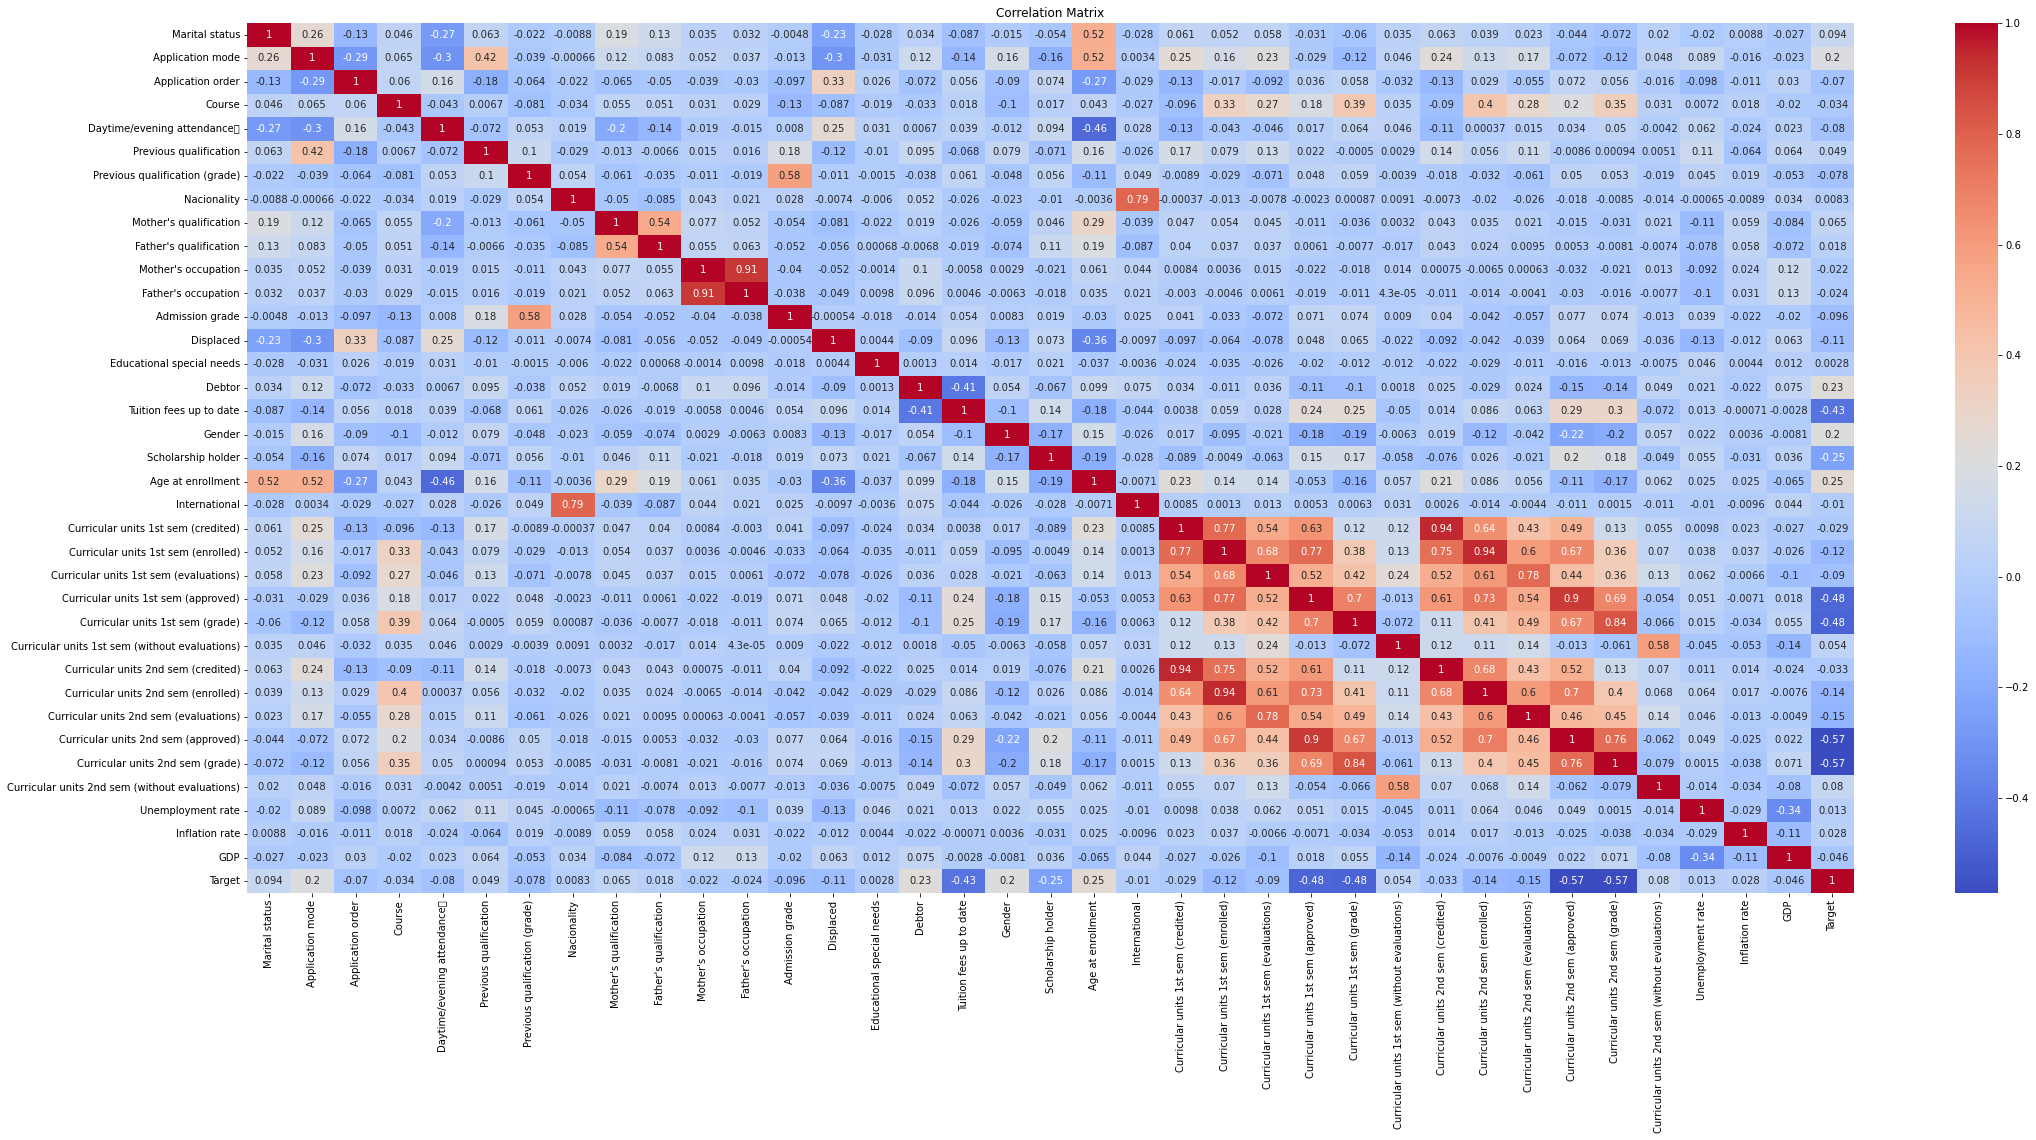

In [91]:
# Compute and visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
corr_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(36, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [92]:
# Calculate correlations with the target column
correlation_with_target = data.corr()['Target']

# Sort by absolute value while preserving the sign
correlation_sorted_by_abs = correlation_with_target.reindex(correlation_with_target.abs().sort_values(ascending=False).index)

# Convert to a DataFrame for better readability
correlation_factors = correlation_sorted_by_abs.reset_index()
correlation_factors.columns = ['Feature', 'Correlation']

# Display the factors sorted by absolute correlation
print(correlation_factors[1:11])
print(correlation_factors[1:11])

                                Feature  Correlation
1      Curricular units 2nd sem (grade)    -0.571792
2   Curricular units 2nd sem (approved)    -0.569500
3      Curricular units 1st sem (grade)    -0.480669
4   Curricular units 1st sem (approved)    -0.479112
5               Tuition fees up to date    -0.429149
6                     Age at enrollment     0.254215
7                    Scholarship holder    -0.245354
8                                Debtor     0.229407
9                                Gender     0.203983
10                     Application mode     0.198458
                                Feature  Correlation
1      Curricular units 2nd sem (grade)    -0.571792
2   Curricular units 2nd sem (approved)    -0.569500
3      Curricular units 1st sem (grade)    -0.480669
4   Curricular units 1st sem (approved)    -0.479112
5               Tuition fees up to date    -0.429149
6                     Age at enrollment     0.254215
7                    Scholarship holder    -0.

In [93]:
# Get the top 10 correlated factors
top_10_factors = correlation_factors[1:11]['Feature'].tolist()


# Print the top 10 correlated factors as a comma-separated string
print("Top 10 Correlated Factors:", ", ".join(top_10_factors))


Top 10 Correlated Factors: Curricular units 2nd sem (grade), Curricular units 2nd sem (approved), Curricular units 1st sem (grade), Curricular units 1st sem (approved), Tuition fees up to date, Age at enrollment, Scholarship holder, Debtor, Gender, Application mode


- From the correlation matrix, we can tell that the top 10 factors that correlated to students dropout risk are: Curricular units 2nd sem (grade), Curricular units 2nd sem (approved), Curricular units 1st sem (grade), Curricular units 1st sem (approved), Tuition fees up to date, Age at enrollment, Scholarship holder, Debtor, Gender, Application mode.



#### 1.2  Addressing High Correlation


##### Variance Inflation Factor (VIF)

In [94]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant column for VIF calculation
X = add_constant(data.drop(columns=['Target']))  # Drop target column
vif = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Sort by the 'VIF' column in descending order
vif_sorted = vif.sort_values(by='VIF', ascending=False)

# Display the sorted DataFrame
print(vif_sorted)




                                           Feature         VIF
0                                            const  244.818471
23             Curricular units 1st sem (enrolled)   24.482511
29             Curricular units 2nd sem (enrolled)   17.207212
22             Curricular units 1st sem (credited)   16.223547
25             Curricular units 1st sem (approved)   13.103872
28             Curricular units 2nd sem (credited)   12.591785
31             Curricular units 2nd sem (approved)   10.736544
11                             Mother's occupation    5.979421
12                             Father's occupation    5.970843
32                Curricular units 2nd sem (grade)    5.778227
26                Curricular units 1st sem (grade)    5.197275
24          Curricular units 1st sem (evaluations)    4.014065
30          Curricular units 2nd sem (evaluations)    3.386472
21                                   International    2.713637
8                                      Nacionality    2

In [95]:
print(vif_sorted[1:6]['Feature'].tolist())

['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (approved)', 'Curricular units 2nd sem (credited)']


In [96]:
# Find highly correlated pairs
threshold = 0.8  # Define a threshold for high correlation
correlated_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)

# Filter to show only pairs with high correlation and avoid self-correlation
correlated_pairs = correlated_pairs[correlated_pairs < 1]
correlated_pairs = correlated_pairs[correlated_pairs > threshold]

print("Highly Correlated Pairs:")
print(correlated_pairs)


Highly Correlated Pairs:
Curricular units 1st sem (credited)  Curricular units 2nd sem (credited)    0.944811
Curricular units 2nd sem (credited)  Curricular units 1st sem (credited)    0.944811
Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)    0.942627
Curricular units 2nd sem (enrolled)  Curricular units 1st sem (enrolled)    0.942627
Mother's occupation                  Father's occupation                    0.910472
Father's occupation                  Mother's occupation                    0.910472
Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)    0.904002
Curricular units 2nd sem (approved)  Curricular units 1st sem (approved)    0.904002
Curricular units 2nd sem (grade)     Curricular units 1st sem (grade)       0.837170
Curricular units 1st sem (grade)     Curricular units 2nd sem (grade)       0.837170
dtype: float64


In [97]:
data['Total_Credited_Units'] = data['Curricular units 1st sem (credited)'] + data['Curricular units 2nd sem (credited)']
data['Total_Enrolled_Units'] = data['Curricular units 1st sem (enrolled)'] + data['Curricular units 2nd sem (enrolled)']
data['Total_Approved_Units'] = data['Curricular units 1st sem (approved)'] + data['Curricular units 2nd sem (approved)']
data['Average_Grade'] = (data['Curricular units 1st sem (grade)'] + data['Curricular units 2nd sem (grade)']) / 2

data = data.drop(columns=[
    'Curricular units 1st sem (credited)', 
    'Curricular units 2nd sem (credited)',
    'Curricular units 1st sem (enrolled)', 
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 1st sem (approved)', 
    'Curricular units 2nd sem (approved)',
    'Curricular units 1st sem (grade)', 
    'Curricular units 2nd sem (grade)'
])

# Verify the changes
print(data.columns)

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target', 'Total_Credited_Units',
       'Total_Enrolled_Units', 'Total_Approved_Units', 'Average_Grade'],
      dtype='object')


To address multicollinearity in the dataset, I identified highly correlated features and combined them into composite features to simplify the dataset while retaining the essential information. 

Specifically, I created new features: Total_Credited_Units (sum of credited units from the 1st and 2nd semesters), Total_Enrolled_Units (sum of enrolled units), Total_Approved_Units (sum of approved units), and Average_Grade (average grade across semesters). 

After creating these new features, I dropped the original individual features to eliminate redundancy and simplify the dataset, ensuring that multicollinearity does not negatively affect model performance. This process balances dimensionality reduction with retaining the predictive power of the original data.


In [98]:
# Calculate correlations with the target column
correlation_with_target = data.corr()['Target']

# Sort by absolute value while preserving the sign
correlation_sorted_by_abs = correlation_with_target.reindex(correlation_with_target.abs().sort_values(ascending=False).index)

# Convert to a DataFrame for better readability
correlation_factors = correlation_sorted_by_abs.reset_index()
correlation_factors.columns = ['Feature', 'Correlation']

# Display the factors sorted by absolute correlation
print(correlation_factors[1:11])
# Get the top 10 correlated factors
top_10_factors = correlation_factors[1:11]['Feature'].tolist()


# Print the top 10 correlated factors as a comma-separated string
print("Top 10 Correlated Factors to the Target:\n", ", ".join(top_10_factors))

                                   Feature  Correlation
1                            Average_Grade    -0.550759
2                     Total_Approved_Units    -0.536756
3                  Tuition fees up to date    -0.429149
4                        Age at enrollment     0.254215
5                       Scholarship holder    -0.245354
6                                   Debtor     0.229407
7                                   Gender     0.203983
8                         Application mode     0.198458
9   Curricular units 2nd sem (evaluations)    -0.154999
10                    Total_Enrolled_Units    -0.134498
Top 10 Correlated Factors to the Target:
 Average_Grade, Total_Approved_Units, Tuition fees up to date, Age at enrollment, Scholarship holder, Debtor, Gender, Application mode, Curricular units 2nd sem (evaluations), Total_Enrolled_Units


- Based on the correlation analysis, the strongest factors influencing student dropout risk include Average_Grade and Total_Approved_Units, both showing negative correlations of approximately -0.55. This indicates that higher grades and more approved units are associated with a lower likelihood of dropping out. 
- Other notable factors include Tuition fees up to date (-0.43), suggesting that students with unpaid tuition fees are more likely to drop out, and Age at enrollment (0.25), which shows that older students might have a higher risk of dropping out. 
- Additional factors such as Scholarship holder (-0.24), Debtor (0.23), and Gender (0.20) demonstrate moderate correlations, indicating their relevance in predicting student outcomes. 
- Factors with weaker correlations, such as Curricular units 2nd sem (evaluations) (-0.15) and Total_Enrolled_Units (-0.13), may still contribute but have less impact compared to the others. Overall, academic performance, financial stability, and demographic attributes appear to be the most significant predictors of student success or dropout.
-  Broader economic indicators like unemployment rate, inflation rate, and GDP,are uncorrelated with the target

### 2. Pairplot

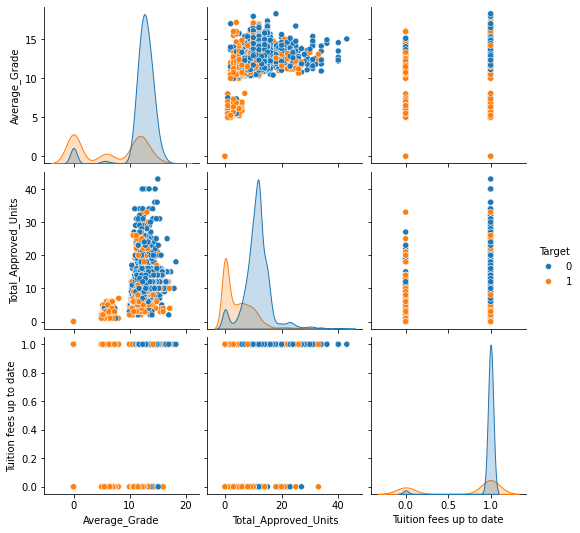

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt


# Pairplot for selected features
selected_features = top_10_factors[:3]  
sns.pairplot(data=data, vars=selected_features, hue='Target')
plt.show()



#### Insights

- Students who do not drop out (Target = 0) tend to have higher Average Grades, with the majority clustering around higher grade values.
- Students who drop out (Target = 1) are more evenly distributed, with many showing lower grades. This indicates a strong negative relationship between Average Grade and dropout likelihood.
- Students who do not drop out (Target = 0) typically have a much higher number of Total Approved Units, clustering towards higher values.
- Students who drop out (Target = 1) are more concentrated at lower values of Total Approved Units.This reinforces that students with fewer approved units are at greater risk of dropping out.
- Students with unpaid tuition fees (Tuition Fees Up to Date = 0) show a higher likelihood of dropping out.
- Students with higher grades are mostly those with tuition fees paid (Tuition Fees Up to Date = 1), and they are less likely to drop out (Target = 0).
- Students with tuition fees up to date tend to have more approved units, further reducing their dropout likelihood.



### 3. Demographic Analysis

In [100]:
data.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Total_Credited_Units,Total_Enrolled_Units,Total_Approved_Units,Average_Grade
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,8.063291,0.150316,11.566139,1.228029,0.001969,0.321203,1.251808,12.502712,9.142405,10.435514
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,3.947951,0.753774,2.663850,1.382711,2.269935,0.466991,4.220239,4.608821,5.960612,4.818530
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,6.000000,0.000000,9.400000,0.300000,-1.700000,0.000000,0.000000,10.000000,5.000000,11.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,8.000000,0.000000,11.100000,1.400000,0.320000,0.000000,0.000000,12.000000,10.000000,12.250000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,10.000000,0.000000,13.900000,2.600000,1.790000,1.000000,0.000000,14.000000,12.000000,13.266667
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,33.000000,12.000000,16.200000,3.700000,3.510000,1.000000,39.000000,46.000000,43.000000,18.283654


In [119]:
number_of_dropouts=len(data[data['Target'] == 1])
print(len(data[data['Target'] == 1])/len(data))

0.3212025316455696


There are 4424 students in this dataset, among which 1421 (32.12%) students dropped out.



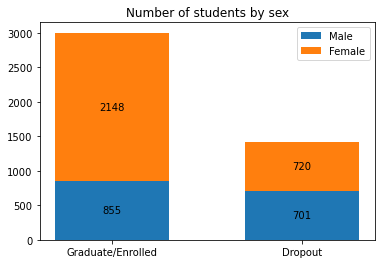

In [143]:
import matplotlib.pyplot as plt

Performance = ('Graduate/Enrolled', 'Dropout')
sex_counts = {
    'Male': np.array(data[data['Gender'] == 1]['Target'].value_counts()),
    'Female': np.array(data[data['Gender'] == 0]['Target'].value_counts()),
}
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
bottom = np.zeros(2)

for sex, sex_count in sex_counts.items():
    p = ax.bar(Performance, sex_count, width, label=sex, bottom=bottom)
    bottom += sex_count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of students by sex')
ax.legend()

plt.show()

Among all the students been studies:
1556 are male students, 701 (45.05%) of them dropped out.
2868 students are female, 720 (25.10%) of them dropped out.


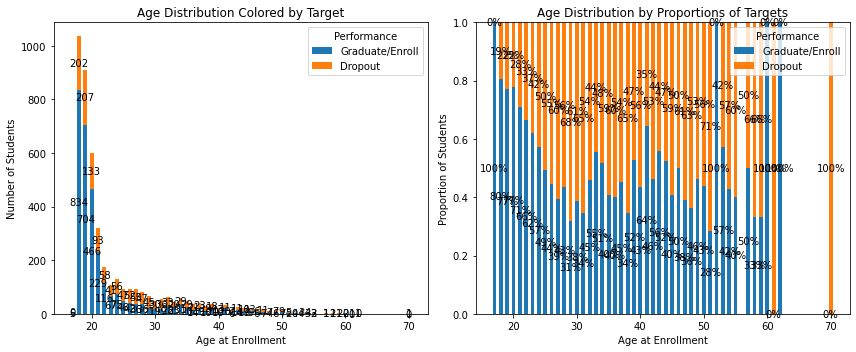

In [153]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



# Prepare the data
ages = sorted(data['Age at enrollment'].unique())  # Get unique ages
performance_counts = {
    'Graduate/Enroll': data[data['Target'] != 1].groupby('Age at enrollment').size(),
    'Dropout': data[data['Target'] == 1].groupby('Age at enrollment').size(),
}

# Align counts with all ages (fill missing age categories with 0)
graduate_enroll_counts = performance_counts['Graduate/Enroll'].reindex(ages, fill_value=0)
dropout_counts = performance_counts['Dropout'].reindex(ages, fill_value=0)

# Bar chart settings

width = 0.6  # Bar width
bottom = np.zeros(len(ages))  # Initialize the bottom for stacking bars

# Create the stacked bar chart
for performance, counts in {'Graduate/Enroll': graduate_enroll_counts, 'Dropout': dropout_counts}.items():
    p = ax1.bar(ages, counts, width, label=performance, bottom=bottom)
    bottom += counts  # Update bottom for the next stack
    ax1.bar_label(p, label_type='center')  # Add labels inside bars

# Customize the chart
ax1.set_title('Age Distribution Colored by Target')
ax1.set_xlabel('Age at Enrollment')
ax1.set_ylabel('Number of Students')
ax1.legend(title='Performance')




# Calculate counts by age and target
age_target_counts = data.groupby(['Age at enrollment', 'Target']).size().unstack(fill_value=0)

# Normalize counts to proportions
age_target_proportions = age_target_counts.div(age_target_counts.sum(axis=1), axis=0)

# Prepare data for the bar chart
ages = age_target_proportions.index
graduate_enroll_proportions = age_target_proportions[0]  # Proportion for Graduate/Enroll (Target=0)
dropout_proportions = age_target_proportions[1]  # Proportion for Dropout (Target=1)

# Bar chart settings
width = 0.6  # Bar width
bottom = np.zeros(len(ages))  # Initialize the bottom for stacking bars

# Create the stacked bar chart
for performance, proportions in {'Graduate/Enroll': graduate_enroll_proportions, 'Dropout': dropout_proportions}.items():
    p = ax2.bar(ages, proportions, width, label=performance, bottom=bottom)
    bottom += proportions  # Update bottom for the next stack
    ax2.bar_label(p, labels=[f"{int(v*100)}%" for v in proportions], label_type='center')  # Add labels as percentages

# Customize the chart
ax2.set_title('Age Distribution by Proportions of Targets')
ax2.set_xlabel('Age at Enrollment')
ax2.set_ylabel('Proportion of Students')
ax2.legend(title='Performance')


plt.tight_layout()


# Show the plots
plt.show()


#### Insights

- Students in the age range of 18-22 show the highest dropout rates both in absolute counts and proportions. This could indicate a higher risk of dropout among traditionally younger students entering higher education.
- Older students, especially those above 30, are less likely to drop out proportionally, though their overall population size is much smaller.
- The very high dropout proportions at extreme ages (e.g., 60-70) are likely due to small sample sizes and might not reflect meaningful patterns.

## Supervised Machine Learning Models Model Selection

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score


X = data.drop('Target', axis=1)
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
select_models=[]
reacall_of_models=[]

In [17]:
#define the evaluation function
from sklearn.metrics import accuracy_score, classification_report
def evaluate(classifier):
    y_pred = classifier.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    select_models.append(classifier)
    reacall_of_models.append(recall)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)

### 1. Logistic Regression

- Simple, interpretable, and provides insights into the relationship between predictors and the likelihood of dropout. It works well if the data has a linear relationship and doesn’t require much tuning.
- It struggles to capture non-linear interactions between features, which are likely important in this dataset (e.g., grades and enrollment age). It can also underperform if features are highly correlated or the dataset is not well-balanced.

In [18]:

from sklearn.linear_model import LogisticRegression


# train logistic regression model
Logistic_classifier = LogisticRegression(random_state=42)
Logistic_classifier.fit(X_train, y_train)

#elvaluate the classifier
evaluate(Logistic_classifier)



Confusion Matrix:
[[538  31]
 [124 192]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       569
           1       0.86      0.61      0.71       316

    accuracy                           0.82       885
   macro avg       0.84      0.78      0.79       885
weighted avg       0.83      0.82      0.82       885



/Users/lauriezeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- The model is only identifying 61% of actual dropouts.
- This is low and means that 39% of true dropouts are being missed (false negatives).
This is problematic since the primary goal is to identify as many at-risk students as possible to provide support.
A low recall indicates that many students who truly need help are not being flagged by the mode

### 2. Decision Tree and hyperparameter optimization

In [19]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
classifier.fit(X_train,y_train)

#elvaluate the classifier
evaluate(classifier)

Confusion Matrix:
[[501  68]
 [ 91 225]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       569
           1       0.77      0.71      0.74       316

    accuracy                           0.82       885
   macro avg       0.81      0.80      0.80       885
weighted avg       0.82      0.82      0.82       885




- The decision tree model performs well in predicting not dropout (class 0), with high recall (0.95).
- High precision (0.88) for predicting dropouts ensures that most predicted dropouts are correct.
- The recall for dropouts (class 1) is up to 0.71, wchih is a big jump compared to the logistic model. However, the model fails to identify 29% of students at risk of dropping out.

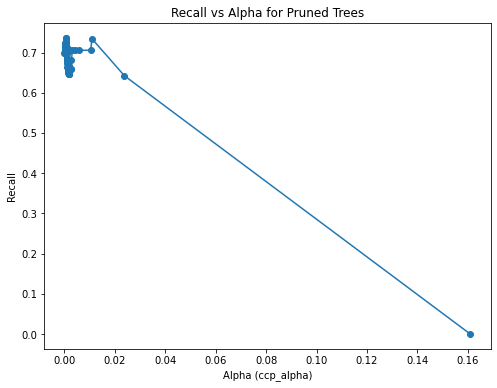

Best tree alpha: 0.00047094282754073653


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

# Get the pruning path
path = classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Train trees with different ccp_alpha values
trees = []
recalls = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)
    
    # Evaluate recall for each pruned tree
    y_pred = clf.predict(X_test)
    recalls.append(recall_score(y_test, y_pred))

# Plot recall vs alpha
plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, recalls, marker='o')
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Recall")
plt.title("Recall vs Alpha for Pruned Trees")
plt.show()

# Select the best tree based on recall
best_tree = trees[recalls.index(max(recalls))]
print("Best tree alpha:", ccp_alphas[recalls.index(max(recalls))])



In [21]:
# Refit the decision tree with the best alpha
best_dt_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=0.02501223651478395)
best_dt_classifier.fit(X_train, y_train)

# Evaluate the model
evaluate(best_dt_classifier)



Confusion Matrix:
[[510  59]
 [113 203]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       569
           1       0.77      0.64      0.70       316

    accuracy                           0.81       885
   macro avg       0.80      0.77      0.78       885
weighted avg       0.80      0.81      0.80       885



After the tunning, we don't see a improvement on recall or F1 score of class 1.

### 3. Random Forest and hyperparameter optimization

We will start from the default setting, then use gridsearch to tune the model.

In [22]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 2000,random_state=42)
classifier.fit(X_train,y_train)

#elvaluate the classifier
evaluate(classifier)


Confusion Matrix:
[[537  32]
 [ 93 223]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       569
           1       0.87      0.71      0.78       316

    accuracy                           0.86       885
   macro avg       0.86      0.82      0.84       885
weighted avg       0.86      0.86      0.85       885



- The model performs well in predicting not dropout (class 0), with high recall (0.94).
High precision (0.86) for predicting dropouts ensures that most predicted dropouts are correct.
- The recall for dropouts (class 1) is only 71%, meaning the model fails to identify 29% of students at risk of dropping out.


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [500, 1000, 2000]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='recall')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}


In [24]:
best_rf_model = grid_search.best_estimator_
evaluate(best_rf_model)

Confusion Matrix:
[[538  31]
 [ 92 224]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       569
           1       0.88      0.71      0.78       316

    accuracy                           0.86       885
   macro avg       0.87      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885



- By experimenting with hyperparameter tuning with gridsearch, the model barely get improved. Also, it took too long to compute.


### 4. GradientBoost

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification

# Step 1: Create a synthetic classification dataset
X, y = make_classification(
    n_samples=1000, n_features=10, n_classes=2, random_state=42
)
# Step 2: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Initialize the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(
    n_estimators=100,     # Number of boosting stages
    learning_rate=0.1,    # Shrinks the contribution of each tree
    max_depth=3,          # Depth of each tree
    random_state=42       # For reproducibility
)

# Step 4: Train the model
classifier=gbc
classifier.fit(X_train, y_train)

#elvaluate the classifier
evaluate(classifier)


Confusion Matrix:
[[123  12]
 [ 26 139]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       135
           1       0.92      0.84      0.88       165

    accuracy                           0.87       300
   macro avg       0.87      0.88      0.87       300
weighted avg       0.88      0.87      0.87       300



In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Initialize the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    scoring='f1',  # Use F1-score to evaluate imbalanced data
    cv=5,          # 5-fold cross-validation
    n_jobs=-1      # Use all available cores
)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [27]:
best_gbc_model = grid_search.best_estimator_
evaluate(best_gbc_model)

Confusion Matrix:
[[124  11]
 [ 24 141]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       135
           1       0.93      0.85      0.89       165

    accuracy                           0.88       300
   macro avg       0.88      0.89      0.88       300
weighted avg       0.89      0.88      0.88       300



It improve the Recall for "Dropout" from 0.7 to 0.85. The model correctly identified 85% of actual dropouts. This indicates that only 15% of dropouts are missed.

### 5. AdaBoost

#### 5.1 AdaBoost Uses Logistic Regression as the base estimator

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import recall_score


# Use Logistic Regression as the base estimator
base_model = LogisticRegression(max_iter=1000)
adaboost = AdaBoostClassifier(base_estimator=base_model, n_estimators=50, random_state=42)

# Train AdaBoost
classifier=adaboost.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Recall: 0.8242424242424242


#### 5.2 AdaBoost Uses Support Vector Machines as the base estimator

In [29]:
from sklearn.svm import SVC
base_model = SVC(probability=True, kernel='linear')
adaboost = AdaBoostClassifier(base_estimator=base_model, n_estimators=50, random_state=42)


# Train AdaBoost
classifier=adaboost.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Recall: 0.8


#### 5.2 Use Decision Trees as the base estimator

In [30]:

from sklearn.tree import DecisionTreeClassifier
base_model = DecisionTreeClassifier(max_depth=3)
adaboost = AdaBoostClassifier(base_estimator=base_model, n_estimators=50, random_state=42)

# Train AdaBoost
classifier=adaboost.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Recall: 0.8545454545454545


#### 5.3 Use Randomforest as the base estimator

In [31]:

from sklearn.ensemble import RandomForestClassifier
base_model = RandomForestClassifier(max_depth=20)
adaboost = AdaBoostClassifier(base_estimator=base_model, n_estimators=500, random_state=42)

# Train AdaBoost
ada_rf=adaboost.fit(X_train, y_train)
y_pred = ada_rf.predict(X_test)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Recall: 0.8606060606060606


This is the best adaboost model so far.

In [32]:
best_ada=ada_rf
evaluate(best_ada)


Confusion Matrix:
[[122  13]
 [ 23 142]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       135
           1       0.92      0.86      0.89       165

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



### 6.  Support Vector Machines

In [33]:
from sklearn.svm import SVC

# Create an SVM classifier with a linear kernel
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

# Fit the SVM on the training data
svm_classifier.fit(X_train, y_train)

# Evaluate the model
evaluate(svm_classifier)


Confusion Matrix:
[[120  15]
 [ 31 134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       135
           1       0.90      0.81      0.85       165

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



## Results Comparison

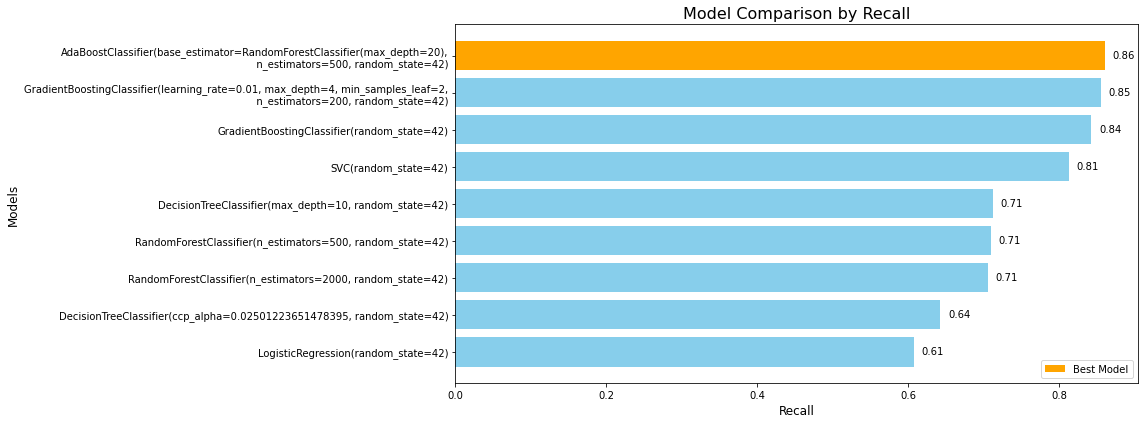

In [158]:
import matplotlib.pyplot as plt

# Ensure the 'Model' column is of string type
model_compare['Model'] = model_compare['Model'].astype(str)

# Sort the data (if not already sorted)
model_compare = model_compare.sort_values(by='Recall', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(16, 6))
plt.barh(model_compare['Model'], model_compare['Recall'], color='skyblue')

# Highlight the best model
best_model = model_compare.iloc[-1]  # The model with the highest recall
plt.barh(best_model['Model'], best_model['Recall'], color='orange', label='Best Model')

# Add titles and labels
plt.title('Model Comparison by Recall', fontsize=16)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Models', fontsize=12)

# Annotate the recall scores
for i, (recall, model) in enumerate(zip(model_compare['Recall'], model_compare['Model'])):
    plt.text(recall + 0.01, i, f'{recall:.2f}', va='center', fontsize=10)

# Add a legend
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


### Best Model: AdaBoostClassifier

In [155]:
model_evaluation = pd.DataFrame({
    'Model': select_models,
    'Recall':reacall_of_models 
})

model_compare=model_evaluation.sort_values(by='Recall', ascending=False,)
model_compare = model_compare.reset_index(drop=True)
print(model_compare)
# Dynamically select the model with the highest recall
best_model_all = model_compare.iloc[0]['Model']  # The top row after sorting
print("The best model of all is: " + str(best_model_all))



                                               Model    Recall
0  ((DecisionTreeClassifier(max_depth=20, max_fea...  0.860606
1  ([DecisionTreeRegressor(criterion='friedman_ms...  0.854545
2  ([DecisionTreeRegressor(criterion='friedman_ms...  0.842424
3                               SVC(random_state=42)  0.812121
4  DecisionTreeClassifier(max_depth=10, random_st...  0.712025
5  (DecisionTreeClassifier(max_features='auto', r...  0.708861
6  (DecisionTreeClassifier(max_features='auto', r...  0.705696
7  DecisionTreeClassifier(ccp_alpha=0.02501223651...  0.642405
8                LogisticRegression(random_state=42)  0.607595
The best model of all is: AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=20),
                   n_estimators=500, random_state=42)


## Insights and Recommendations

The best-performing model for predicting student dropouts is the AdaBoost Classifier with a Random Forest base estimator (max depth = 20, n_estimators = 500). In this scenario, Recall is the most critical metric, as the goal is to identify students at risk of dropping out (class 1) and minimize False Negatives—cases where at-risk students are misclassified as "Not Dropout," missing the opportunity for timely intervention.

### Recommendations to address dropout risks effectively:

- Focus interventions on students with lower grades, fewer approved units, unpaid tuition fees, as these are the most significant risk factors.
- Enhance academic support programs, such as tutoring or advising, targeting students with declining performance or low unit completion rates.
- Provide financial aid or payment plans to students struggling with tuition payments.
- Use the AdaBoost model to continuously identify high-risk students and refine intervention strategies based on model predictions.

By aligning resources with these insights, hopefully institutions can proactively reduce dropout rates and improve overall student success.